<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/Python_Automation_ANFS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Automation Short Course
by John Hogland 3/21/2022

In this short course we will discuss python programming fundamentals and explore some basic functionality within the raster_tools package using Apalachicola National Forest vegetated polygons.

## Apalachicola NF stands (ANFS)
ANFS depict the spatial geometry of vegetated polygons (management units) within the Apalachicola National Forest.

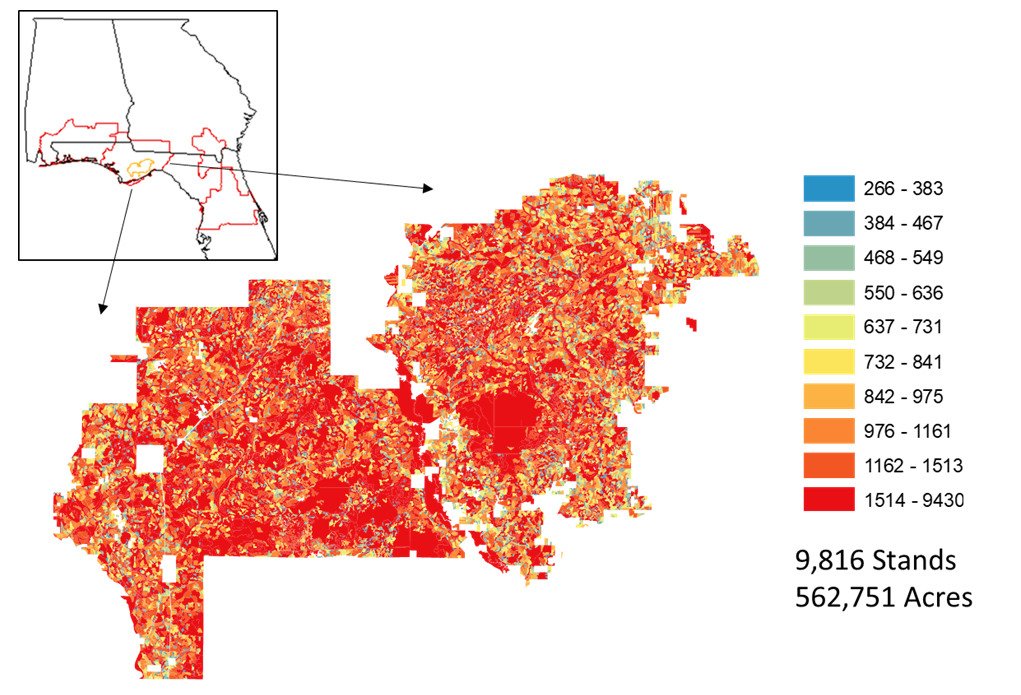


1. ANFStands.shp - Apalachicola National Forest Stands
2. 9,816 Stands (all the forest)
3. 562,751 Acres (all the forest)


## Install raster_tools and upgrade dependencies

In [ ]:
!pip install --upgrade gdown
!pip install --upgrade numba
!pip install --upgrade geopandas
!pip install mapclassify
!pip install --upgrade datascience
!pip install --upgrade gym
!pip install --upgrade folium
!pip install raster_tools
!pip install schedule
!pip install graphviz

## Get the data

In [ ]:
import gdown, zipfile

url='https://drive.google.com/file/d/1flAZzNiYDkdOuwvN0m4rfshOMgojXoGC/view?usp=sharing'
outfl= r'./ANF_Notebook_data.zip'
gdown.download(url=url,output=outfl,quiet=False,fuzzy=True)

with zipfile.ZipFile(outfl, 'r') as zip_ref:
    zip_ref.extractall(".")

# Automation 1: Creating a script and running it from a cell, as a module, or from command line
## Hello World from a cell (shift enter)

In [ ]:
print('Hello World')

### Exercise: Hello World from python file
1. Create a new python file called "HelloWorld.py" in root directory (same location as your notebook)
2. Open the file
3. Type: print('Hello World')
4. Save file
5. Create new code cell and import HelloWorld

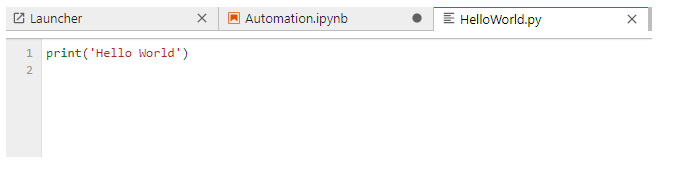

### Exercise: Hello World from shell (local or Colab Pro)
1. Launch PowerShell - File->New->Terminal
2. Type python HelloWorld.py - this will print out Hello World in the terminal

## Looking at the data - create a script that:
1. loads the data
2. lists the fields
3. creates a map of the data using Acres field
4. lists how many stands and acres are in the subset

In [ ]:
from raster_tools import open_vectors
import numpy as np

anfs=open_vectors('ANFStands.shp')
print("Field Names:\n" + str(anfs.field_names))
gdf=anfs.data.compute()
gdf.plot(column='ACRES',cmap='Spectral_r',legend=True,figsize=(14,8))
print('Total acres = ' + str(np.round(gdf['ACRES'].sum(),decimals=2)))
print('Total polygons = ' + str(gdf.shape[0]))

## Convert the script into a function that takes parameters

In [ ]:
def map_sum(path, field, cmap='Spectral'):
    anfs=open_vectors(path)
    print("Field Names:\n" + str(anfs.field_names))
    gdf=anfs.data.compute()
    gdf.plot(column='ACRES',cmap='Spectral_r',legend=True,figsize=(14,8))
    print('Total acres = ' + str(gdf['ACRES'].sum()))
    print('Total polygons = ' + str(gdf.shape[0]))
    return gdf

anfs_path = 'ANFStands.shp'
column_field = 'ACRES'
color_ramp = 'Spectral'
g=map_sum(anfs_path,column_field,color_ramp)

### Exercise: Convert your function into a module called map_and_sum
1. make a new python file called map_and_sum.py
2. add: from raster_tools import open_vectors
3. copy the map_sum function and save (upload if using Colab)
4. add a cell and import your module, set variables, and call the function

How does python know where map_and_sum is located?

### Exercise: Adding system arguments and calling from command line (local or Colab Pro)
1. make a new python file called arg_map_and_sum.py
2. add import sys module
3. add import map_and_sum module
5. add three sys.arg parameters (e.g.,path=sys.argv[1])
6. call the map_sum function using the sys.argv values within the arg_map_and_sum module
7. from command line: python arg_map_and_sum.py 'C:\Users\jshogland\Documents\temp\ANFStands.shp' 'ACRES'

Why didn't the map print?


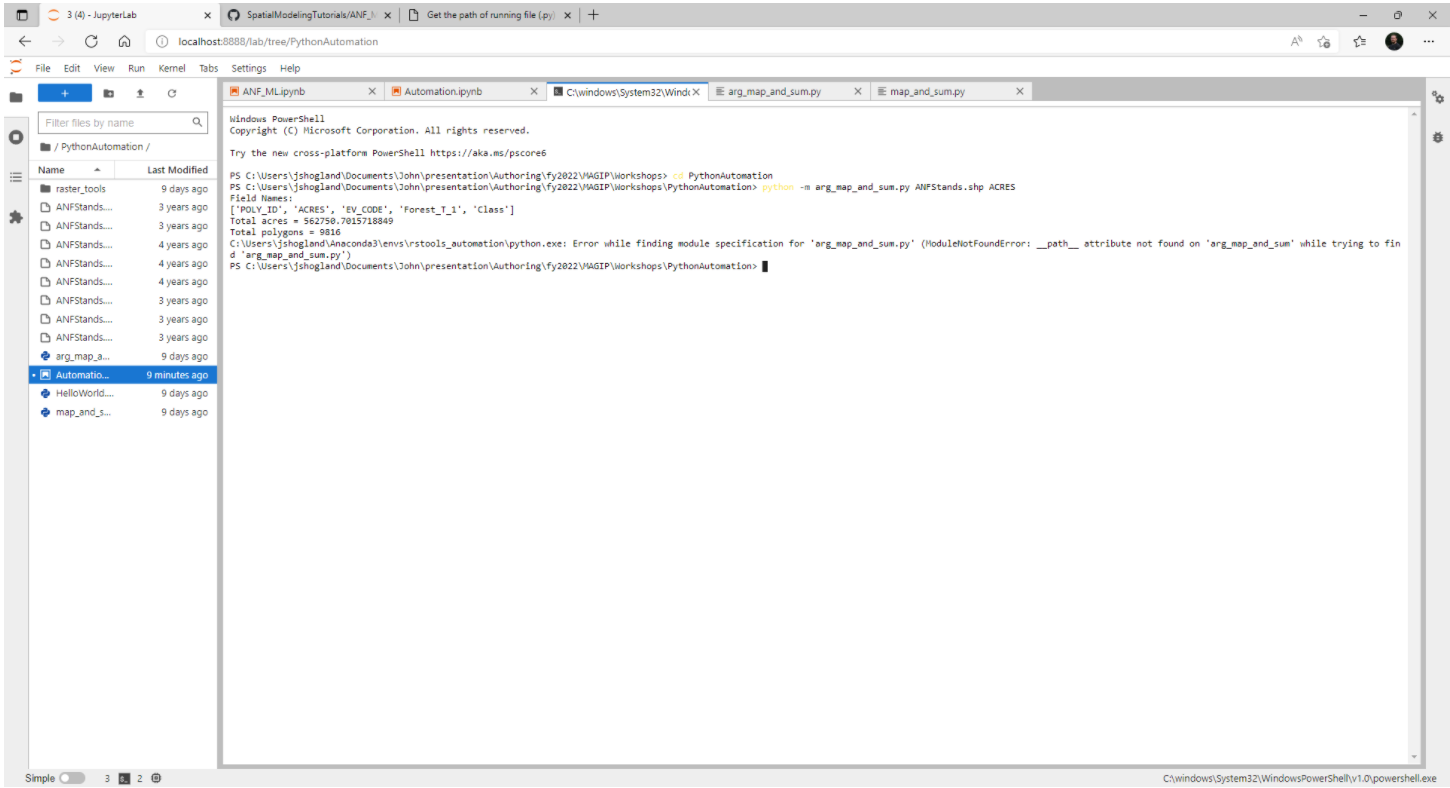

___________________________________________________________________________________
# Break
___________________________________________________________________________________

# Automation 2: Classes and inheritance
## Hello World 2

In [ ]:
def basic_hello(text):
    print(text)

class c_hello:
    def __init__(self,text):
        self.text = text
    
    def hello(self):
        print(self.text + " World from c_hello")

class c_hello2(c_hello):
    def __init__(self, text):
        c_hello.__init__(self,text)
    def hello2(self):
        print(self.text + " World from c_hello2")
        

## Use the definitions and classes

In [ ]:
print('Message from definition')
basic_hello('Hello from basic_hello')

#c_hello
print('\nMessage from c_hello object')
ch=c_hello('Hello')
ch.hello()

#c_hello2
print('\nMessages from c_hello2 object')
ch2=c_hello2('Hello')
ch2.hello()
ch2.hello2()

### Exercise: Hello World 2 as a module
- create a module called hello_world2.py
- copy code into that module
- save the module (upload if using Colab)
- add a cell and use the module to print out the various hello world statements

## Creating shape metrics
- create a spatial_metrics class
- pa function
- fractal function

In [ ]:
import pandas as pd
class spatial_metrics:
    def __init__(self,vct):
        self.vct = vct
        self.geo = self.vct.geometry
        self.area = self.vct.data.area
        self.perimeter = self.vct.data.length
    
    def pa(self):
        return self.perimeter/self.area
    
    def fractal(self):
        return np.log(self.area)/(np.log(self.perimeter)+np.log(0.25))

## Use the spatial_metrics class to estimate perimeter to area ratio (pa) and fractal dimension (fractal)
- results will be a delayed processing series
- merge series to the attribute table of anfs
- view the data

In [ ]:
spm=spatial_metrics(anfs)
frc=spm.fractal()
pa=spm.pa()
anfs_sp=anfs.data.assign(PA=pa,FRACTAL=frc)
anfs_sp.compute()

### Exercise: Shape metrics class as a module
- create a metrics module
- add a code cell and use the module and classes to add fields to anfs_sp1
- view the data

## Plot PA and FRACTAL surfaces
- use the map_sum function
- use a for loop to fill subplots

In [ ]:
import matplotlib.pyplot as plt
f, axes = plt.subplots(figsize=(20, 6), ncols=2, nrows=1,tight_layout=True)

cnt=0
clms=['FRACTAL','PA']
for x in clms:
    axes[cnt].set_title(x, fontdict={'fontsize': 25, 'fontweight' : 3})
    anfs_sp.compute().plot(ax=axes[cnt],column=x,cmap='Spectral',legend=True)
    cnt+=1

## Save anfs_sp as anfs_sp

In [ ]:
anfs_sp.compute().to_file('anfs_sp.shp')

### Exercise: Plot PA and FRACTAL surface using shape metrics module
- add code cell
- copy previous code cell and change anfs_sp to anfs_sp1 

___________________________________________________________________________________
# Break
___________________________________________________________________________________

# Automation 3: Scheduled Tasks
- The schedule package
- create a job_that_executes_once() function
- create a job
- create a loop

In [ ]:
import schedule, time

# function
def job_that_executes_once():
    spm=spatial_metrics(anfs)
    frc=spm.fractal()
    pa=spm.pa()
    anfs_sp=anfs.data.assign(PA=pa,FRACTAL=frc)
    anfs_sp.compute().to_file('anfs_sp_sch.shp')
    print("finished")
    return schedule.CancelJob

# job
schedule.every(30).seconds.do(job_that_executes_once)

# loop
while True:
    schedule.run_pending()
    if not schedule.jobs:
        break
    time.sleep(1)


### Exercise: Schedule a job to add area and perimeter fields to anfs dataset.
- add code cell
- copy previous code cell and change the definition to include area and perimeter.
- hint, you will need to add to your spatial_metrics class (inheritance)
- Save file as 'anfs_sp_sch2.shp

# Automation 4: User Interface and Widgets
- simplify the geometry of anfs_sp for viewing
- create an interactive map with area, StreetMaps, and area imagery as a backdrop
- add widgets to the map
- save as a html file

## Simplify the geometry
Simplifying the geometry is necessary so that the polygons will display within Colab. If we want to keep the fidelity of the data we can work locally or can save the file to a HTML file and download from Colab.

In [ ]:
anfs_sp_simple = anfs_sp.set_geometry(anfs_sp.simplify(50))

## Create an interactive map

In [ ]:
import folium
from folium import plugins
p1=anfs_sp_simple.compute().explore(name="Fractal",column='FRACTAL',style_kwds={'opacity':0.7})

#add ESRI's tiled imagery to potential base maps
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Imagery',
        overlay = False,
        control = True
       ).add_to(p1)

#show the interactive map
p1

## Add widgets

In [ ]:
#add widgets to the map

fs=plugins.Fullscreen()
dr=plugins.Draw()
lc=plugins.LocateControl()
ms=plugins.MeasureControl(position='bottomleft')
msp=plugins.MousePosition()
ms.add_to(p1)
msp.add_to(p1)
lc.add_to(p1)
dr.add_to(p1)
fs.add_to(p1)
folium.LayerControl().add_to(p1)
p1

## Save map as html
- download if working in Colab and open in web browser

In [ ]:
p1.save('anf.html')

### Exercise: Create an interactive map for PA and save as a HTML
- add a coding cell
- repeat Create an interactive map cell but specify PA as the column



# This ends the Python Automation Short Course

## Check out the other notebooks:
- https://github.com/jshogland/SpatialModelingTutorials/tree/main/Notebooks 

## References
- Spatial Modeling Notebooks:  https://github.com/jshogland/SpatialModelingTutorials
- Raster-Tools GitHub: https://github.com/UM-RMRS/raster_tools
- Hogland's Spatial Solutions: https://sites.google.com/view/hoglandsspatialsolutions/home
- Dask: https://dask.org/
- Geopandas:https://geopandas.org/en/stable/
- Xarray: https://docs.xarray.dev/en/stable/
- Jupyter: https://jupyter.org/
- Anaconda:https://www.anaconda.com/
- VS Code: https://code.visualstudio.com/
- ipywidgets: https://ipywidgets.readthedocs.io/en/latest/
- numpy:https://numpy.org/
- matplotlib:https://matplotlib.org/
- folium: https://python-visualization.github.io/folium/
- pandas: https://pandas.pydata.org/
- os: https://docs.python.org/3/library/os.html